***Importamos las librerías necesarias :***

In [3]:
import shutil
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

***Guardamos las imágenes con sus respectivas clases en "complete_df" :***

In [4]:
zip_path = './raw-img.zip'

complete_df = pd.DataFrame()

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = [f for f in zip_ref.namelist() if f.startswith('raw-img/') and f.lower().endswith(('.jpeg','.jpg','.png'))]
    complete_df['file_name'] = pd.Series(file_list)
    complete_df['class_name'] = complete_df['file_name'].map(lambda x: x.split('/')[-2])

#### COMPROBACIÓN ####
print("Número total de imágenes:", len(complete_df))
class_counts = complete_df['class_name'].value_counts()
print(class_counts)

Número total de imágenes: 4669
class_name
aragna      659
perro       614
gallina     579
caballo     509
oveja       470
vaca        449
gato        415
mariposa    357
ardilla     314
elefante    303
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [5]:
train_df, test_df = train_test_split(complete_df, test_size=0.2, random_state=42, stratify=complete_df['class_name'])

#### COMPROBACIÓN ####
print(f"Nº de imágenes en train: {len(train_df)}")
print(train_df['class_name'].value_counts())
print()
print(f"Nº de imágenes en test: {len(test_df)}")
print(test_df['class_name'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head())
print()
print("Ejm. conjunto test:")
print(test_df.head())

Nº de imágenes en train: 3735
class_name
aragna      527
perro       491
gallina     463
caballo     407
oveja       376
vaca        359
gato        332
mariposa    286
ardilla     251
elefante    243
Name: count, dtype: int64

Nº de imágenes en test: 934
class_name
aragna      132
perro       123
gallina     116
caballo     102
oveja        94
vaca         90
gato         83
mariposa     71
ardilla      63
elefante     60
Name: count, dtype: int64

Ejm. conjunto train:
                                              file_name class_name
1451  raw-img/perro/OIP-WoBlwPywbUunAGkav8oS2wHaFP.jpeg      perro
3063  raw-img/ardilla/OIP-XqwdlRXhVZG6niIOcTkgEQHaGY...    ardilla
3433  raw-img/mariposa/OIP-Wg_dyeVXtfFw8X3EK3xyPAAAA...   mariposa
4146  raw-img/aragna/OIP-Yhum4muYolk1GHGjslGbYAHaEM....     aragna
3192  raw-img/ardilla/OIP-Y_qUC89aWJb7hu_Iw7KfmgHaFU...    ardilla

Ejm. conjunto test:
                                              file_name class_name
822    raw-img/vaca/OIP-wQzNCiq-qtW

***Función que muestra las imágenes de entrenamiento y test antes del pre-procesado :***

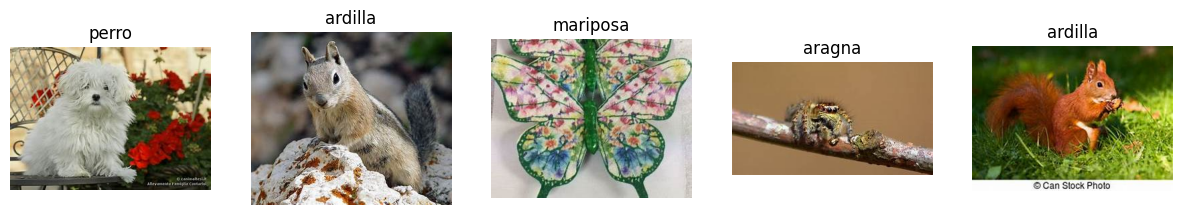

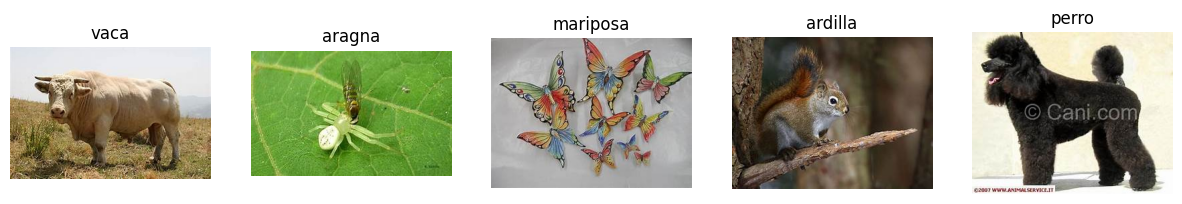

In [14]:
def mostrar_imagenes_antes_preprocesado(df, num_imagenes):
    plt.figure(figsize=(15, 15))
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for i in range(num_imagenes):
            image_path = df['file_name'].iloc[i]
            class_name = df['class_name'].iloc[i]
            with zip_ref.open(image_path) as image_file:
                image = Image.open(image_file).convert("RGB")
            plt.subplot(5, num_imagenes, i + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')
    plt.show()

mostrar_imagenes_antes_preprocesado(train_df, 5)
mostrar_imagenes_antes_preprocesado(test_df, 5)

***Hacemos el pre-procesado de imágenes :***

In [5]:
IMG_SIZE = (227, 227)
X_train = []
X_train_gray = []
y_train = []
X_test = []
X_test_gray = []
y_test = []

#Función que carga y preprocesa una imagen
def preprocesado_imagen(zip_ref, image_path):
    with zip_ref.open(image_path) as image_file:
        image = Image.open(image_file)
        #RGB
        image_rgb = image.convert("RGB")
        image_rgb = image_rgb.resize(IMG_SIZE)
        image_rgb = img_to_array(image_rgb) / 255.0
        #Escala de grises
        image_gray = image.convert("L")
        image_gray = image_gray.resize(IMG_SIZE)
        image_gray = img_to_array(image_gray) / 255.0

        return image_rgb, image_gray

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    #Procesar imágenes del conjunto de entrenamiento
    for index, row in train_df.iterrows():
        image_rgb, image_gray = preprocesado_imagen(zip_ref, row['file_name'])
        X_train.append(image_rgb)
        X_train_gray.append(image_gray)
        y_train.append(row['class_name'])

    #Procesar imágenes del conjunto de prueba
    for index, row in test_df.iterrows():
        image_rgb, image_gray = preprocesado_imagen(zip_ref, row['file_name'])
        X_test.append(image_rgb)
        X_test_gray.append(image_gray)
        y_test.append(row['class_name'])

#RGB
X_train = np.array(X_train, dtype="float32")
X_test = np.array(X_test, dtype="float32")

#Escala de grises
X_train_gray = np.array(X_train_gray, dtype="float32")
X_test_gray = np.array(X_test_gray, dtype="float32")

#Codificar las etiquetas y realizar one-hot encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

#### COMPROBACIÓN ####
print(f"X_train RGB: {X_train.shape}")
print(f"X_train Escala grises: {X_train_gray.shape}")
print(f"X_test RGB: {X_test.shape}")
print(f"X_test Escala grises: {X_test_gray.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train RGB: (3735, 227, 227, 3)
X_train Escala grises: (3735, 227, 227, 1)
X_test RGB: (934, 227, 227, 3)
X_test Escala grises: (934, 227, 227, 1)
y_train: (3735, 10)
y_test: (934, 10)


***Función que muestra las imágenes de entrenamiento y test después del pre-procesado :***

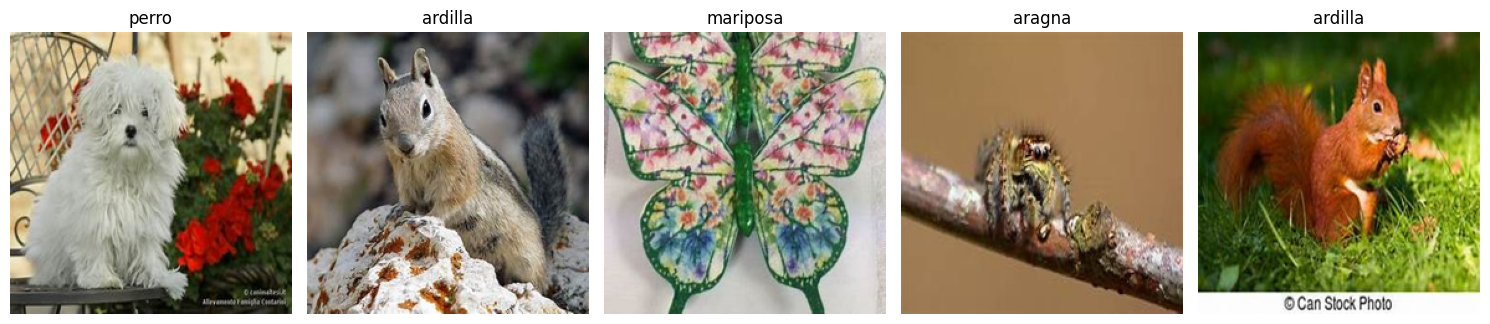

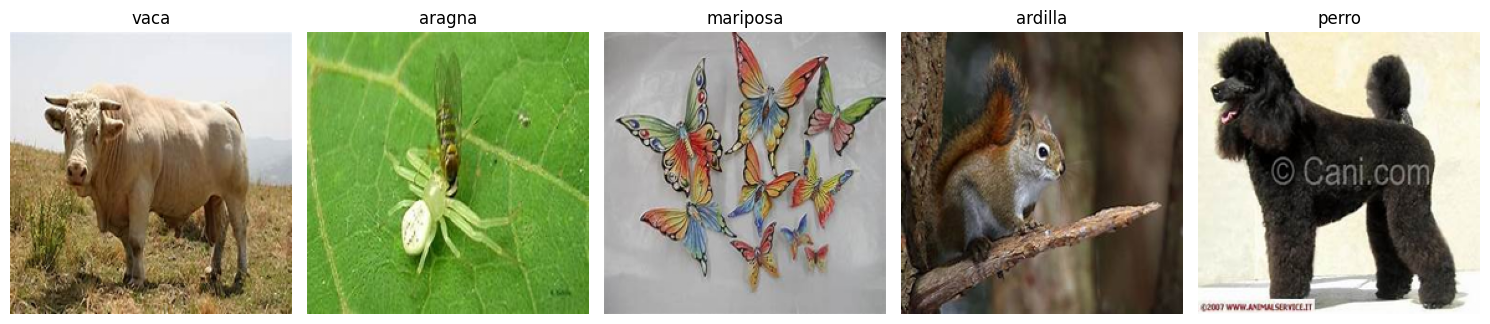

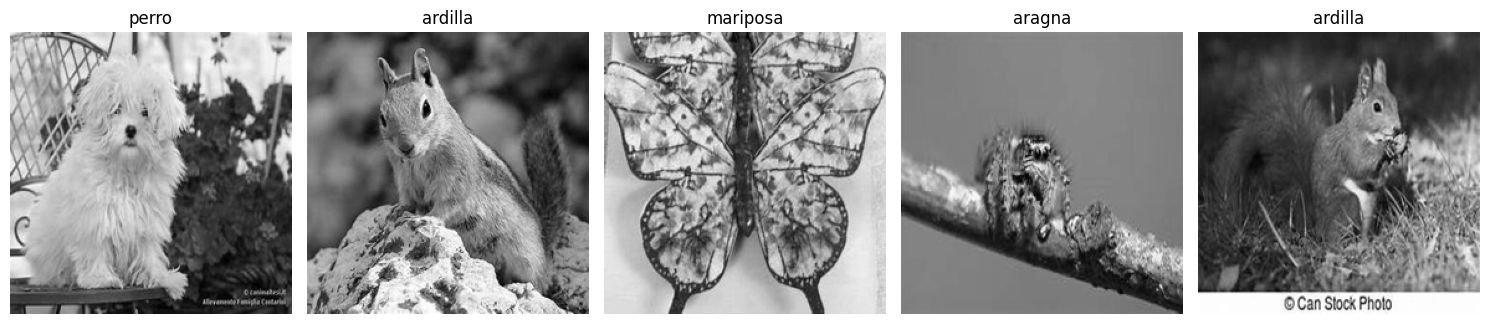

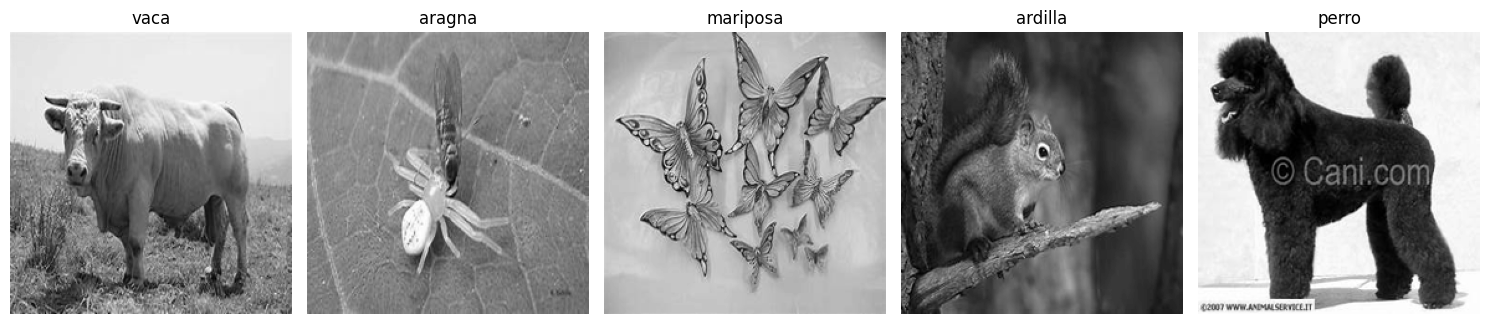

In [16]:
def mostrar_imagenes_despues_preprocesado(x_data, y_data, num_samples, label_encoder):
    plt.figure(figsize=(15,15))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_data[i], cmap='gray')
        class_index = np.argmax(y_data[i])
        class_name = label_encoder.inverse_transform([class_index])[0]
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

mostrar_imagenes_despues_preprocesado(X_train, y_train, 5, label_encoder)
mostrar_imagenes_despues_preprocesado(X_test, y_test, 5, label_encoder)
mostrar_imagenes_despues_preprocesado(X_train_gray, y_train, 5, label_encoder)
mostrar_imagenes_despues_preprocesado(X_test_gray, y_test, 5, label_encoder)

# ***MLP_v1***

In [7]:
def MLP_v1(input_shape, num_classes):
  modelo_MLP_v1 = Sequential()

  modelo_MLP_v1.add(Flatten(input_shape=input_shape))
  modelo_MLP_v1.add(Dense(150, activation='relu'))
  modelo_MLP_v1.add(Dense(150, activation='relu'))
  modelo_MLP_v1.add(Dense(num_classes, activation='softmax'))

  modelo_MLP_v1.compile(loss=CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

  return modelo_MLP_v1

In [8]:
tensorboardMLP_v1 = TensorBoard(log_dir='logs/MLP_v1')

In [9]:
input_shape = (227, 227, 3)
modelo_MLP_v1 = MLP_v1(input_shape, 10)
historial = modelo_MLP_v1.fit(X_train, y_train, batch_size=32, validation_split=0.2, epochs=100, callbacks=[tensorboardMLP_v1])
modelo_MLP_v1.save('modelo_MLP_v1.h5')

c:\Users\jesus\OneDrive\Escritorio\P2_RN\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - accuracy: 0.1257 - loss: 35.3784 - val_accuracy: 0.2249 - val_loss: 6.3177
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.1672 - loss: 4.7658 - val_accuracy: 0.1968 - val_loss: 3.5283
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 0.2569 - loss: 2.8963 - val_accuracy: 0.1914 - val_loss: 3.2963
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - accuracy: 0.2628 - loss: 2.5927 - val_accuracy: 0.1847 - val_loss: 2.8841
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - accuracy: 0.2547 - loss: 2.7269 - val_accuracy: 0.1754 - val_loss: 3.3120
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 0.2363 - loss: 2.5165 - val_accuracy: 0.2075 - val_loss: 2.3965
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 179ms/step - accuracy: 0.3080 - loss: 1.9900 - val_accuracy: 0.2450 - val_loss: 2.3153
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 179ms/step - accuracy: 0.3392 - loss: 1.9164 -

# ***MLP_v2 (RGB)***

In [11]:
def MLP_v2(input_shape, num_classes):
  modelo_MLP_v2 = Sequential()

  modelo_MLP_v2.add(Flatten(input_shape=input_shape))
  modelo_MLP_v2.add(Dense(150, activation='relu'))
  modelo_MLP_v2.add(Dense(150, activation='relu'))
  modelo_MLP_v2.add(Dense(num_classes, activation='softmax'))

  optimizer = SGD(learning_rate=0.001, momentum=0.9)
  modelo_MLP_v2.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

  return modelo_MLP_v2

In [13]:
tensorboardMLP_v2_RGB = TensorBoard(log_dir='logs/MLP_v2_RGB')

In [14]:
input_shape = (227, 227, 3)
modelo_MLP_v2_RGB = MLP_v2(input_shape, 10)
historial = modelo_MLP_v2_RGB.fit(X_train, y_train, batch_size=32, validation_split=0.2, epochs=100, callbacks=[tensorboardMLP_v2_RGB])
modelo_MLP_v2_RGB.save('modelo_MLP_v2_RGB.h5')

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.1304 - loss: 2.4240 - val_accuracy: 0.1419 - val_loss: 2.2359
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.1791 - loss: 2.2093 - val_accuracy: 0.1794 - val_loss: 2.1822
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.2258 - loss: 2.1214 - val_accuracy: 0.2035 - val_loss: 2.1757
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.2512 - loss: 2.0829 - val_accuracy: 0.2303 - val_loss: 2.0795
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.2616 - loss: 2.0440 - val_accuracy: 0.2303 - val_loss: 2.1149
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.2654 - loss: 2.0075 - val_accuracy: 0.2570 - val_loss: 2.0763
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.2745 - loss: 2.0128 - val_accuracy: 0.2811 - val_loss: 2.0420
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.2940 - loss: 1.9551 - val_accuracy: 0.

# ***MLP_v2 (Escala de grises)***

In [9]:
tensorboardMLP_v2_GRAY = TensorBoard(log_dir='logs/MLP_v2_GRAY')

In [13]:
input_shape = (227, 227, 1)
modelo_MLP_v2_GRAY = MLP_v2(input_shape, 10)
historial = modelo_MLP_v2_GRAY.fit(X_train_gray, y_train, batch_size=32, validation_split=0.2, epochs=100, callbacks=[tensorboardMLP_v2_GRAY])
modelo_MLP_v2_GRAY.save('modelo_MLP_v2_GRAY.h5')

c:\Users\jesus\OneDrive\Escritorio\P2_RN\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1272 - loss: 2.3447 - val_accuracy: 0.1727 - val_loss: 2.2306
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.1545 - loss: 2.2448 - val_accuracy: 0.1151 - val_loss: 2.3136
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.1601 - loss: 2.2424 - val_accuracy: 0.1901 - val_loss: 2.1925
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.2117 - loss: 2.1784 - val_accuracy: 0.1834 - val_loss: 2.2154
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.2192 - loss: 2.1702 - val_accuracy: 0.2048 - val_loss: 2.1680
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.2274 - loss: 2.1518 - val_accuracy: 0.2075 - val_loss: 2.1790
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.2521 - loss: 2.1066 - val_accuracy: 0.2410 - val_loss: 2.1630
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.2577 - loss: 2.1138 - val_accuracy: 0.

# ***AlexNet_v1***

In [23]:
def Alexnet_v1(input_shape, num_classes):

  modelo_AlexNet_v1 = Sequential()

  #Capa 1: Convolución + MaxPooling
  modelo_AlexNet_v1.add(Conv2D(96, kernel_size=(11, 11), strides=4, padding='valid', activation='relu', input_shape=input_shape))
  modelo_AlexNet_v1.add(MaxPooling2D(pool_size=(3, 3), strides=2))

  #Capa 2: Convolución + MaxPooling
  modelo_AlexNet_v1.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
  modelo_AlexNet_v1.add(MaxPooling2D(pool_size=(3, 3), strides=2))

  #Capas 3-5: Convolución
  modelo_AlexNet_v1.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
  modelo_AlexNet_v1.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
  modelo_AlexNet_v1.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
  modelo_AlexNet_v1.add(MaxPooling2D(pool_size=(3, 3), strides=2))

  #Capas densas (fully connected)
  modelo_AlexNet_v1.add(Flatten())
  modelo_AlexNet_v1.add(Dense(4096, activation='relu'))
  modelo_AlexNet_v1.add(Dense(4096, activation='relu'))
  modelo_AlexNet_v1.add(Dense(num_classes, activation='softmax'))

  modelo_AlexNet_v1.compile(optimizer='adam', loss = CategoricalCrossentropy(), metrics=['accuracy'])

  return modelo_AlexNet_v1

In [25]:
tensorboardAlexNet_v1 = TensorBoard(log_dir='logs/AlexNet_v1')

In [26]:
input_shape = (227, 227, 3)
modelo_AlexNet_v1 = Alexnet_v1(input_shape, 10)
historial = modelo_AlexNet_v1.fit(X_train, y_train, batch_size=32, validation_split=0.2, epochs=100, callbacks=[tensorboardAlexNet_v1])
modelo_AlexNet_v1.save('modelo_AlexNet_v1.h5')

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 85s 857ms/step - accuracy: 0.1356 - loss: 3.9263 - val_accuracy: 0.1339 - val_loss: 2.2708
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 880ms/step - accuracy: 0.1368 - loss: 2.2767 - val_accuracy: 0.1312 - val_loss: 2.2695
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 881ms/step - accuracy: 0.1485 - loss: 2.2772 - val_accuracy: 0.1312 - val_loss: 2.2727
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 878ms/step - accuracy: 0.1388 - loss: 2.2754 - val_accuracy: 0.1312 - val_loss: 2.2685
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 84s 891ms/step - accuracy: 0.1278 - loss: 2.2741 - val_accuracy: 0.1312 - val_loss: 2.2694
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 857ms/step - accuracy: 0.1484 - loss: 2.2660 - val_accuracy: 0.1312 - val_loss: 2.2702
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 860ms/step - accuracy: 0.1445 - loss: 2.2762 - val_accuracy: 0.1312 - val_loss: 2.2692
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 863ms/step - accuracy: 0.1433 - loss: 2.2705 - 

# ***AlexNet_v2 (RGB)***

In [13]:
def Alexnet_v2(input_shape, num_classes):

  modelo_AlexNet_v2 = Sequential()

  #Capa 1: Convolución + MaxPooling
  modelo_AlexNet_v2.add(Conv2D(96, kernel_size=(11, 11), strides=4, padding='valid', activation='relu', input_shape=input_shape))
  modelo_AlexNet_v2.add(MaxPooling2D(pool_size=(3, 3), strides=2))

  #Capa 2: Convolución + MaxPooling
  modelo_AlexNet_v2.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
  modelo_AlexNet_v2.add(MaxPooling2D(pool_size=(3, 3), strides=2))

  #Capas 3-5: Convolución
  modelo_AlexNet_v2.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
  modelo_AlexNet_v2.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
  modelo_AlexNet_v2.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
  modelo_AlexNet_v2.add(MaxPooling2D(pool_size=(3, 3), strides=2))

  #Capas densas (fully connected)
  modelo_AlexNet_v2.add(Flatten())
  modelo_AlexNet_v2.add(Dense(4096, activation='relu'))
  modelo_AlexNet_v2.add(Dropout(0.5))
  modelo_AlexNet_v2.add(Dense(4096, activation='relu'))
  modelo_AlexNet_v2.add(Dropout(0.5))
  modelo_AlexNet_v2.add(Dense(num_classes, activation='softmax'))

  optimizer = SGD(learning_rate=0.001, momentum=0.9)
  modelo_AlexNet_v2.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

  return modelo_AlexNet_v2


In [28]:
tensorboardAlexNet_v2_RGB = TensorBoard(log_dir='logs/AlexNet_v2_RGB')

In [29]:
input_shape = (227, 227, 3)
modelo_AlexNet_v2_RGB = Alexnet_v2(input_shape, 10)
historial = modelo_AlexNet_v2_RGB.fit(X_train, y_train, batch_size=32, validation_split=0.2, epochs=100, callbacks=[tensorboardAlexNet_v2_RGB])
modelo_AlexNet_v2_RGB.save('modelo_AlexNet_v2_RGB.h5')

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 70s 735ms/step - accuracy: 0.1071 - loss: 2.2956 - val_accuracy: 0.1312 - val_loss: 2.2625
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 69s 737ms/step - accuracy: 0.1346 - loss: 2.2725 - val_accuracy: 0.1312 - val_loss: 2.2611
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 70s 747ms/step - accuracy: 0.1501 - loss: 2.2686 - val_accuracy: 0.1553 - val_loss: 2.2502
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 69s 737ms/step - accuracy: 0.1590 - loss: 2.2581 - val_accuracy: 0.1419 - val_loss: 2.2394
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 69s 732ms/step - accuracy: 0.1559 - loss: 2.2516 - val_accuracy: 0.1807 - val_loss: 2.2203
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 69s 737ms/step - accuracy: 0.1938 - loss: 2.2122 - val_accuracy: 0.2209 - val_loss: 2.1612
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 71s 754ms/step - accuracy: 0.2024 - loss: 2.1737 - val_accuracy: 0.2490 - val_loss: 2.1300
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 70s 739ms/step - accuracy: 0.2211 - loss: 2.1287 - 

# ***AlexNet_v2 (Escala de grises)***

In [11]:
tensorboardAlexNet_v2_GRAY = TensorBoard(log_dir='logs/AlexNet_v2_GRAY')

In [14]:
input_shape = (227, 227, 1)
modelo_AlexNet_v2_GRAY = Alexnet_v2(input_shape, 10)
historial = modelo_AlexNet_v2_GRAY.fit(X_train_gray, y_train, batch_size=32, validation_split=0.2, epochs=100, callbacks=[tensorboardAlexNet_v2_GRAY])
modelo_AlexNet_v2_GRAY.save('modelo_AlexNet_v2_GRAY.h5')

c:\Users\jesus\OneDrive\Escritorio\P2_RN\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 635ms/step - accuracy: 0.1007 - loss: 2.2997 - val_accuracy: 0.1312 - val_loss: 2.2804
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 653ms/step - accuracy: 0.1324 - loss: 2.2783 - val_accuracy: 0.1312 - val_loss: 2.2661
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 657ms/step - accuracy: 0.1480 - loss: 2.2656 - val_accuracy: 0.1580 - val_loss: 2.2651
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 661ms/step - accuracy: 0.1604 - loss: 2.2657 - val_accuracy: 0.1312 - val_loss: 2.2623
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 662ms/step - accuracy: 0.1371 - loss: 2.2793 - val_accuracy: 0.1312 - val_loss: 2.2592
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 63s 672ms/step - accuracy: 0.1586 - loss: 2.2669 - val_accuracy: 0.1660 - val_loss: 2.2536
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 63s 673ms/step - accuracy: 0.1523 - loss: 2.2529 - val_accuracy: 0.1339 - val_loss: 2.2541
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 64s 676ms/step - accuracy: 0.1533 - loss: 2.2564 - 

# ***AlexNet_v3 (optimizer = Adam)***

In [8]:
def AlexNet_v3_Adam(input_shape, num_classes):
    #Carga el modelo base VGG16 preentrenado en ImageNet
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    #Congela las capas convolucionales de VGG16
    base_model.trainable = False

    modelo_AlexNet_v3_Adam = Sequential()
    
    #Capas convolucionales de VGG16
    modelo_AlexNet_v3_Adam.add(base_model)

    #Capas densas (fully connected)
    modelo_AlexNet_v3_Adam.add(Flatten())
    modelo_AlexNet_v3_Adam.add(Dense(4096, activation='relu'))
    modelo_AlexNet_v3_Adam.add(Dropout(0.5))
    modelo_AlexNet_v3_Adam.add(Dense(4096, activation='relu'))
    modelo_AlexNet_v3_Adam.add(Dropout(0.5))
    modelo_AlexNet_v3_Adam.add(Dense(num_classes, activation='softmax'))
    
    modelo_AlexNet_v3_Adam.compile(optimizer=Adam(learning_rate=0.001),loss=CategoricalCrossentropy(),metrics=['accuracy'])
    
    return modelo_AlexNet_v3_Adam

In [ ]:
tensorboardAlexNet_v3_Adam = TensorBoard(log_dir='logs/AlexNet_v3_Adam')

In [9]:
input_shape = (227, 227, 3)
num_classes = 10
modelo_AlexNet_v3_Adam = AlexNet_v3_Adam(input_shape, num_classes)
historial = modelo_AlexNet_v3_Adam.fit(X_train, y_train,batch_size=32,validation_split=0.2,epochs=30,callbacks=[tensorboardAlexNet_v3_Adam])
modelo_AlexNet_v3_Adam.save('modelo_AlexNet_v3_Adam.h5')

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 422s 4s/step - accuracy: 0.2862 - loss: 9.6584 - val_accuracy: 0.6653 - val_loss: 1.0551
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.6147 - loss: 1.0983 - val_accuracy: 0.6720 - val_loss: 1.0023
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - accuracy: 0.6237 - loss: 1.1273 - val_accuracy: 0.6613 - val_loss: 0.9803
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 361s 4s/step - accuracy: 0.6373 - loss: 1.0170 - val_accuracy: 0.7376 - val_loss: 0.7678
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.6856 - loss: 0.8859 - val_accuracy: 0.7309 - val_loss: 0.8788
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 359s 4s/step - accuracy: 0.6715 - loss: 0.9348 - val_accuracy: 0.7497 - val_loss: 0.7361
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 354s 4s/step - accuracy: 0.6668 - loss: 0.9124 - val_accuracy: 0.7577 - val_loss: 0.7796
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.7195 - loss: 0.7813 - val_accuracy: 0.7724 - v

# ***AlexNet_v3 (optimizer = SGD)***

In [19]:
def AlexNet_v3_SGD(input_shape, num_classes):
    #Carga el modelo base VGG16 preentrenado en ImageNet
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    #Congela las capas convolucionales de VGG16
    base_model.trainable = False

    modelo_AlexNet_v3_SGD = Sequential()
    
    #Capas convolucionales de VGG16
    modelo_AlexNet_v3_SGD.add(base_model)

    #Capas densas (fully connected)
    modelo_AlexNet_v3_SGD.add(Flatten())
    modelo_AlexNet_v3_SGD.add(Dense(4096, activation='relu'))
    modelo_AlexNet_v3_SGD.add(Dropout(0.5))
    modelo_AlexNet_v3_SGD.add(Dense(4096, activation='relu'))
    modelo_AlexNet_v3_SGD.add(Dropout(0.5))
    modelo_AlexNet_v3_SGD.add(Dense(num_classes, activation='softmax'))
    
    modelo_AlexNet_v3_SGD.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),loss=CategoricalCrossentropy(),metrics=['accuracy'])
    
    return modelo_AlexNet_v3_SGD

In [ ]:
tensorboardAlexNet_v3_SGD = TensorBoard(log_dir='logs/AlexNet_v3_SGD')

In [22]:
input_shape = (227, 227, 3)
num_classes = 10
modelo_AlexNet_v3_SGD = AlexNet_v3_SGD(input_shape, num_classes)
historial = modelo_AlexNet_v3_SGD.fit(X_train, y_train,batch_size=32,validation_split=0.2,epochs=30,callbacks=[tensorboardAlexNet_v3_SGD])
modelo_AlexNet_v3_SGD.save('modelo_AlexNet_v3_SGD.h5')

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 378s 4s/step - accuracy: 0.1613 - loss: 2.5132 - val_accuracy: 0.4444 - val_loss: 1.5217
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.4194 - loss: 1.6627 - val_accuracy: 0.5917 - val_loss: 1.1928
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.5226 - loss: 1.3143 - val_accuracy: 0.6506 - val_loss: 0.9884
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.6010 - loss: 1.1186 - val_accuracy: 0.6934 - val_loss: 0.9026
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.6656 - loss: 0.9806 - val_accuracy: 0.7309 - val_loss: 0.7953
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.6847 - loss: 0.9175 - val_accuracy: 0.7162 - val_loss: 0.8161
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.7194 - loss: 0.8335 - val_accuracy: 0.7229 - val_loss: 0.7773
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.7150 - loss: 0.8059 - val_accuracy: 0.7564 - v

# ***CNN_v1***

In [6]:
def CNN_v1(input_shape, num_classes):

  modelo_CNN_v1 = Sequential()

  #Capa 1: Convolución + MaxPooling
  modelo_CNN_v1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  modelo_CNN_v1.add(MaxPooling2D(pool_size=(2, 2)))

  #Capa 2: Convolución + MaxPooling
  modelo_CNN_v1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  modelo_CNN_v1.add(MaxPooling2D(pool_size=(2, 2)))

  #Capa 3: Convolución + MaxPooling
  modelo_CNN_v1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  modelo_CNN_v1.add(MaxPooling2D(pool_size=(2, 2)))

  #Capas densas (fully connected)
  modelo_CNN_v1.add(Flatten())
  modelo_CNN_v1.add(Dense(128, activation='relu'))
  modelo_CNN_v1.add(Dense(num_classes, activation='softmax'))

  modelo_CNN_v1.compile(optimizer='adam', loss = CategoricalCrossentropy(), metrics=['accuracy'])

  return modelo_CNN_v1

In [ ]:
tensorboardCNN_v1 = TensorBoard(log_dir='logs/CNN_v1')

In [ ]:
input_shape = (227, 227, 3)
modelo_CNN_v1 = CNN_v1(input_shape, 10)
historial = modelo_CNN_v1.fit(X_train, y_train, batch_size=32, validation_split=0.2, epochs=100, callbacks=[tensorboardCNN_v1])
modelo_CNN_v1.save('modelo_CNN_v1.h5')

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 492ms/step - accuracy: 0.1480 - loss: 2.7267 - val_accuracy: 0.2316 - val_loss: 2.1415
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 486ms/step - accuracy: 0.3015 - loss: 1.9781 - val_accuracy: 0.3481 - val_loss: 1.8489
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 466ms/step - accuracy: 0.4320 - loss: 1.6322 - val_accuracy: 0.3548 - val_loss: 1.8588
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 468ms/step - accuracy: 0.6062 - loss: 1.2107 - val_accuracy: 0.4043 - val_loss: 1.8177
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 473ms/step - accuracy: 0.7710 - loss: 0.7364 - val_accuracy: 0.4270 - val_loss: 2.2009
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 472ms/step - accuracy: 0.8959 - loss: 0.3426 - val_accuracy: 0.4244 - val_loss: 2.7084
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 45s 476ms/step - accuracy: 0.9601 - loss: 0.1376 - val_accuracy: 0.4003 - val_loss: 3.6252
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 472ms/step - accuracy: 0.9597 - loss: 0.1456 - 

# ***CNN_v1 (Aumento de datos)***

***Aumento de datos***

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range = 0.1,
    height_shift_range=0.1,
    shear_range=10,
    zoom_range = [0.8, 1.2],
    horizontal_flip = True,
    vertical_flip = False
)

validation_datagen = ImageDataGenerator()

***Función que muestra las imágenes modificadas***

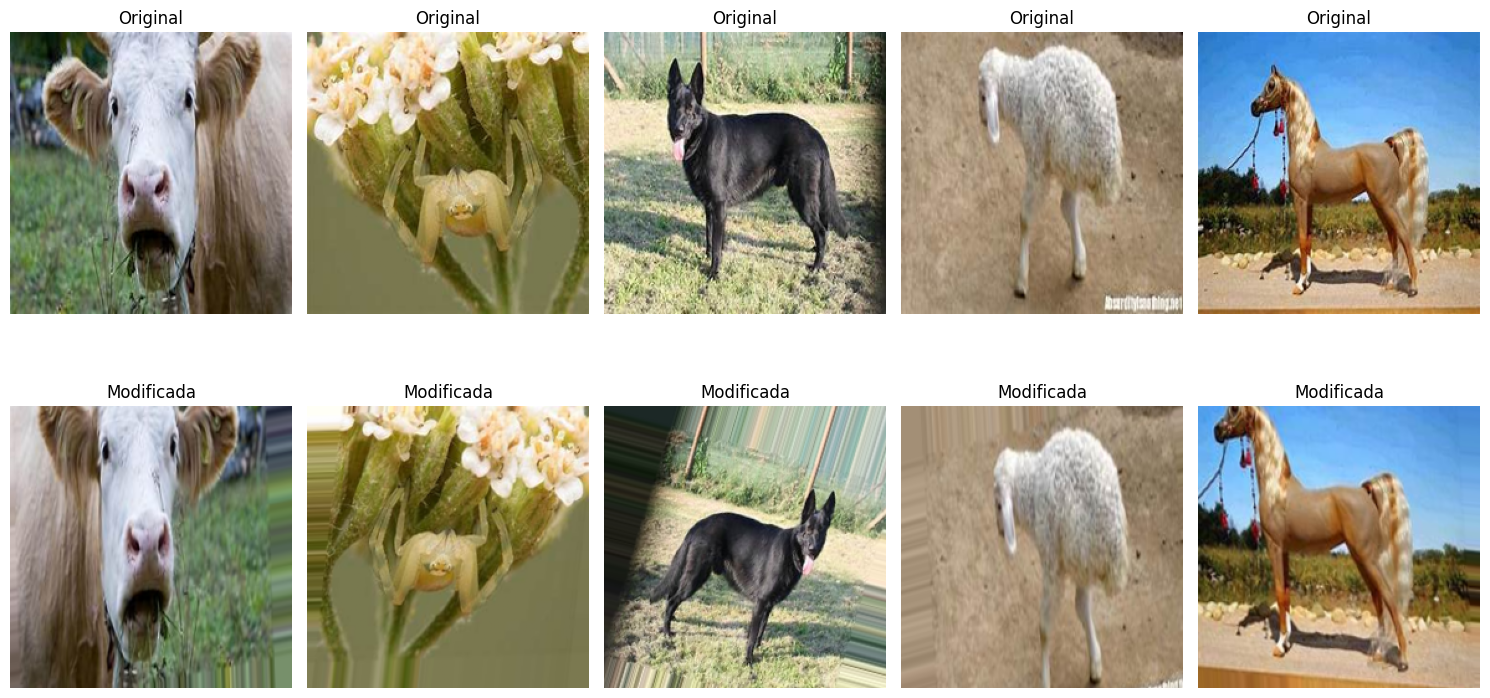

In [18]:
def mostrar_imagenes_modificadas(x_data, num_images=5):
    plt.figure(figsize=(15, 8))

    for i in range(num_images):
        img = x_data[np.random.randint(0, len(x_data))]
        img = np.expand_dims(img, axis=0)

        modified_img = next(train_datagen.flow(img, batch_size=1))[0]

        plt.subplot(2, num_images, i + 1)
        plt.imshow(img[0], cmap='gray' if img.shape[-1] == 1 else None)
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(modified_img, cmap='gray' if modified_img.shape[-1] == 1 else None)
        plt.title("Modificada")
        plt.axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.tight_layout()
    plt.show()

mostrar_imagenes_modificadas(X_train, num_images=5)

In [7]:
X_entrenamiento_RGB = X_train[:2988]
X_validacion_RGB = X_train[2988:]
y_entrenamiento = y_train[:2988]
y_validacion = y_train[2988:]

In [8]:
train_generator = train_datagen.flow(X_entrenamiento_RGB, y_entrenamiento, batch_size=32)
validation_generator = validation_datagen.flow(X_validacion_RGB, y_validacion, batch_size=32)

In [13]:
tensorboardCNN_v1_AUMENTADO = TensorBoard(log_dir='logs/CNN_v1_AUMENTADO')

In [ ]:
input_shape = (227, 227, 3)
num_classes = 10
model = CNN_v1(input_shape, num_classes)
history = model.fit(train_generator, steps_per_epoch=len(X_entrenamiento_RGB)//32, validation_data=validation_generator ,validation_steps=len(X_validacion_RGB)//32, epochs=100, verbose=1, callbacks=[tensorboardCNN_v1_AUMENTADO])
model.save('modelo_CNN_v1_AUMENTADO.h5')

c:\Users\jesus\OneDrive\Escritorio\P2_RN\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 55s 578ms/step - accuracy: 0.1238 - loss: 2.5852 - val_accuracy: 0.2269 - val_loss: 2.1469
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.1875 - loss: 2.1146 - val_accuracy: 0.1818 - val_loss: 2.0612
Epoch 3/100


C:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


93/93 ━━━━━━━━━━━━━━━━━━━━ 56s 602ms/step - accuracy: 0.2060 - loss: 2.1368 - val_accuracy: 0.2391 - val_loss: 2.0448
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.3438 - loss: 2.0141 - val_accuracy: 0.4545 - val_loss: 1.6019
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 54s 584ms/step - accuracy: 0.2776 - loss: 2.0074 - val_accuracy: 0.3859 - val_loss: 1.7517
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.3750 - loss: 1.9226 - val_accuracy: 0.4545 - val_loss: 1.8264
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 55s 587ms/step - accuracy: 0.3689 - loss: 1.7664 - val_accuracy: 0.3886 - val_loss: 1.8188
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - accuracy: 0.3438 - loss: 1.7802 - val_accuracy: 0.4545 - val_loss: 1.3377
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 55s 588ms/step - accuracy: 0.4016 - loss: 1.7042 - val_accuracy: 0.4280 - val_loss: 1.6072
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.6250 - loss: 1.4120 - val_accuracy: 0

# ***CNN_v2***

In [9]:
def CNN_v2(input_shape, num_classes):
    #Carga el modelo base VGG16 preentrenado en ImageNet
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    #Congela las capas convolucionales de VGG16
    base_model.trainable = False

    modelo_CNN_v2 = Sequential()

    #Capas convolucionales de VGG16
    modelo_CNN_v2.add(base_model)

    #Capas densas (fully connected)
    modelo_CNN_v2.add(Flatten())
    modelo_CNN_v2.add(Dense(128, activation='relu'))
    modelo_CNN_v2.add(Dropout(0.5))
    modelo_CNN_v2.add(Dense(num_classes, activation='softmax'))
    
    modelo_CNN_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return modelo_CNN_v2

In [8]:
tensorboardCNN_v2 = TensorBoard(log_dir='logs/CNN_v2')

In [10]:
input_shape = (227, 227, 3)
modelo_CNN_v2 = CNN_v2(input_shape, 10)
historial = modelo_CNN_v2.fit(X_train, y_train, batch_size=32, validation_split=0.2, epochs=30, callbacks=[tensorboardCNN_v2])
modelo_CNN_v2.save('modelo_CNN_v2.h5')

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.2064 - loss: 2.5646 - val_accuracy: 0.5288 - val_loss: 1.5841
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.3369 - loss: 1.7392 - val_accuracy: 0.6145 - val_loss: 1.2562
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.4008 - loss: 1.5245 - val_accuracy: 0.6533 - val_loss: 1.0734
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.4454 - loss: 1.4074 - val_accuracy: 0.6680 - val_loss: 1.0496
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.5036 - loss: 1.2661 - val_accuracy: 0.7189 - val_loss: 0.9341
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.4809 - loss: 1.2477 - val_accuracy: 0.7028 - val_loss: 0.9445
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.5138 - loss: 1.1951 - val_accuracy: 0.7162 - val_loss: 0.8777
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.5344 - loss: 1.1203 - val_accuracy: 0.7041 - v

# ***CNN_v2 (Aumento de datos)***

In [10]:
tensorboardCNN_v2_AUMENTADO = TensorBoard(log_dir='logs/CNN_v2_AUMENTADO')

In [12]:
input_shape = (227, 227, 3)
modelo_CNN_v2_AUMENTADO = CNN_v2(input_shape, 10)
history = modelo_CNN_v2_AUMENTADO.fit(train_generator, steps_per_epoch=len(X_entrenamiento_RGB)//32, validation_data=validation_generator ,validation_steps=len(X_validacion_RGB)//32, epochs=100, verbose=1, callbacks=[tensorboardCNN_v2_AUMENTADO])
modelo_CNN_v2_AUMENTADO.save('modelo_CNN_v2_AUMENTADO.h5')

c:\Users\jesus\OneDrive\Escritorio\P2_RN\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.1548 - loss: 2.7416 - val_accuracy: 0.3764 - val_loss: 1.8183
Epoch 2/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.3750 - loss: 1.9516

C:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3750 - loss: 1.9516 - val_accuracy: 0.1818 - val_loss: 2.0910
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.2845 - loss: 1.9694 - val_accuracy: 0.4334 - val_loss: 1.6013
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3438 - loss: 1.9286 - val_accuracy: 0.2727 - val_loss: 1.6415
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.2821 - loss: 1.8739 - val_accuracy: 0.4674 - val_loss: 1.5036
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4062 - loss: 1.8101 - val_accuracy: 0.4545 - val_loss: 1.3843
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.3305 - loss: 1.7920 - val_accuracy: 0.5340 - val_loss: 1.3981
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3438 - loss: 1.7400 - val_accuracy: 0.3636 - val_loss: 1.4000
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.3141 - loss: 1.7742 - val_accuracy: 0.5408 - val_l

***Gráficas de los diferentes modelos***

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs --port 6010

***Comprobar predicciones***

In [ ]:
model = tf.keras.models.load_model('modelo_AlexNet_v3_SGD.h5')

30/30 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step


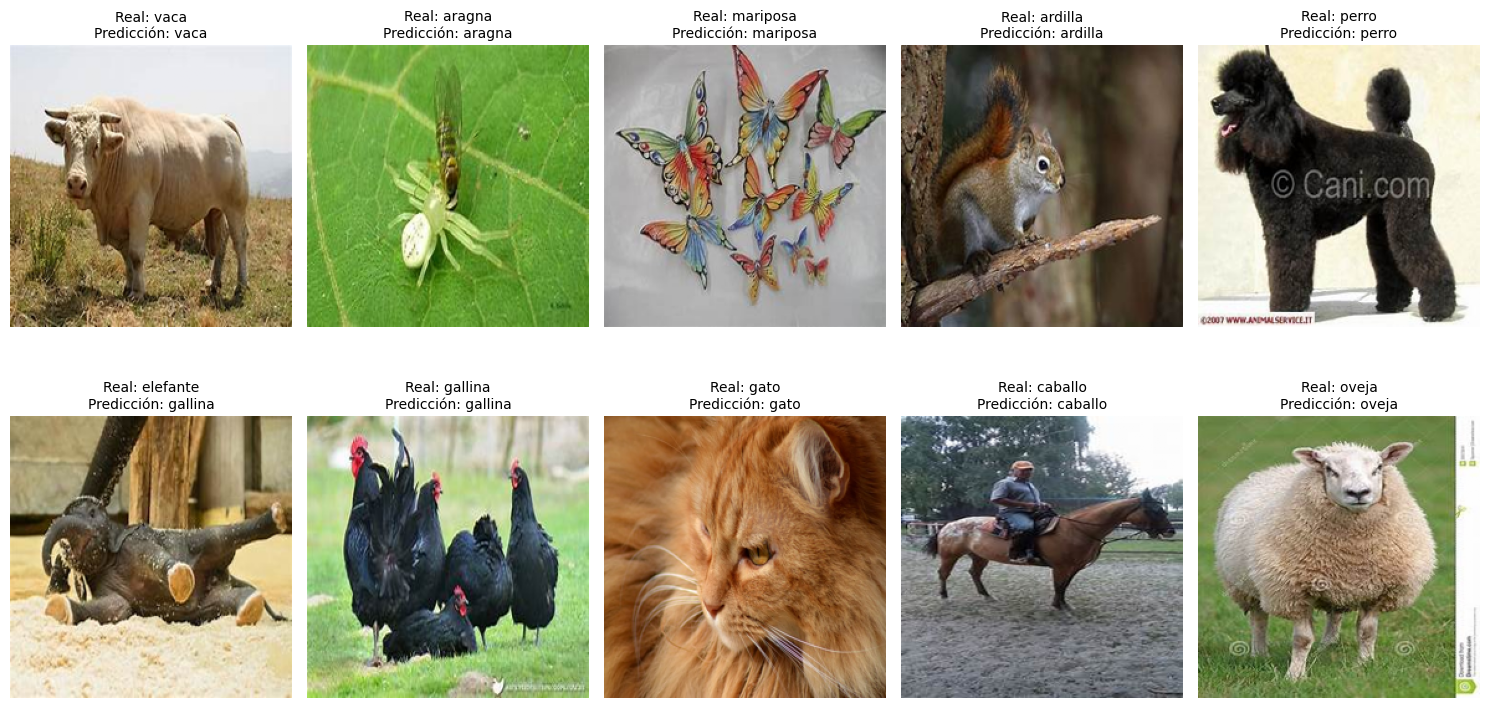

In [19]:
def mostrar_predicciones_por_clase(x_test, y_test, model, label_encoder, num_classes=10):
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_test_decoded = np.argmax(y_test, axis=1)

    ejemplos_clases = {}
    
    for i in range(len(y_test)):
        true_class = y_test_decoded[i]
        if true_class not in ejemplos_clases:
            ejemplos_clases[true_class] = i
        if len(ejemplos_clases) == num_classes:
            break

    filas = 2
    columnas = 5
    plt.figure(figsize=(15, 8))

    for idx, (clase, i) in enumerate(ejemplos_clases.items()):
        plt.subplot(filas, columnas, idx + 1)
        plt.imshow(x_test[i], cmap='gray')
        true_class = label_encoder.inverse_transform([y_test_decoded[i]])[0]
        pred_class = label_encoder.inverse_transform([y_pred[i]])[0]
        plt.title(f"Real: {true_class}\nPredicción: {pred_class}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

mostrar_predicciones_por_clase(X_test, y_test, model, label_encoder, num_classes=10)

